In [1]:
from __future__ import print_function
%matplotlib inline
import argparse
import time
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from torchvision.utils import save_image
from torch.autograd import Variable
from pathlib import Path

# Set random seed for reproducibility
#manualSeed = 999
manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  7276


In [2]:
# Root directory for dataset
#dataroot = "C:/Users/yyhh/Desktop/Morpheus/data/celeba"
dataroot = "data/CustomTile"
# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 2

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 256

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 128

# Size of feature maps in discriminator
ndf = 32

# Number of training epochs
num_epochs = 1000

# Learning rate for optimizers
lr = 0.0001

# Beta1 hyperparam for Adam optimizers
beta1 = 0.9

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [3]:
directoryName = "LSGAN256"+str(lr)+"l"+str(batch_size)+"b"
Path(directoryName).mkdir(parents=True, exist_ok=True)

In [4]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               #transforms.Grayscale(num_output_channels=1),
                               transforms.ToTensor(),

                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                               #transforms.Normalize((0.5,), (0.5,)),

                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(torch.cuda.is_available())
# Plot some training images
real_batch = next(iter(dataloader))

#print(type(real_batch))

True


In [5]:
real_batch = next(iter(dataloader))
#print(type(real_batch))
#print(type(real_batch[0]))
#print(len(real_batch[0][0][0]))
#print(real_batch[0])


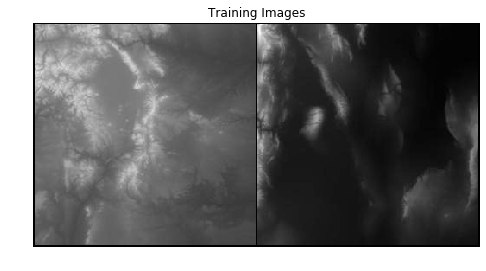

In [6]:
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [7]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [8]:
class Generator(nn.Module):
    def __init__(self, npgu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.init_size = image_size // 4
        self.l1 = nn.Sequential(nn.Linear(100, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 3, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

Now, we can instantiate the generator and apply the ``weights_init``
function. Check out the printed model to see how the generator object is
structured.




In [9]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

#from torchsummary import summary
#summary(netG, input_size= (100, 1024, 4))

Generator(
  (l1): Sequential(
    (0): Linear(in_features=100, out_features=524288, bias=True)
  )
  (conv_blocks): Sequential(
    (0): Upsample(scale_factor=2.0, mode=nearest)
    (1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Upsample(scale_factor=2.0, mode=nearest)
    (5): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): Tanh()
  )
)


Discriminator Code



In [10]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu

        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.model = nn.Sequential(
            *discriminator_block(3, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # The height and width of downsampled image
        ds_size = image_size // 2 ** 4
        self.adv_layer = nn.Linear(128 * ds_size ** 2, 1)

    def forward(self, img):
        out = self.model(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)

        return validity


Now, as with the generator, we can create the discriminator, apply the
``weights_init`` function, and print the model’s structure.




In [11]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
    
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

#from torchsummary import summary
#summary(netD, input_size = (3, 128, 128))

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout2d(p=0.25, inplace=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Dropout2d(p=0.25, inplace=False)
    (6): BatchNorm2d(32, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Dropout2d(p=0.25, inplace=False)
    (10): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (11): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (12): LeakyReLU(negative_slope=0.2, inplace=True)
    (13): Dropout2d(p=0.25, inplace=False)
    (14): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
  )
  (adv_laye

In [12]:
# Initialize BCELoss function
#criterion = nn.BCELoss()
criterion = nn.MSELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(256, nz, 1, 1, device=device)
print(fixed_noise.shape)
# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
#optimizerD = optim.SGD(netD.parameters(), lr=lr)
#optimizerG = optim.SGD(netG.parameters(), lr=lr)

torch.Size([256, 100, 1, 1])


In [13]:
Tensor = torch.cuda.FloatTensor
img_list = []
G_losses = []
D_losses = []
iters = 0
# ----------
#  Training
# ----------
start_time = time.time()
for epoch in range(num_epochs):
    for i, (imgs, _) in enumerate(dataloader):

        # Adversarial ground truths
        valid = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizerG.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], 100))))

        # Generate a batch of images
        gen_imgs = netG(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = criterion(netD(gen_imgs), valid)

        g_loss.backward()
        optimizerG.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizerD.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = criterion(netD(real_imgs), valid)
        fake_loss = criterion(netD(gen_imgs.detach()), fake)
        d_loss = 0.5 * (real_loss + fake_loss)

        d_loss.backward()
        optimizerD.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     d_loss.item(), g_loss.item()))
        
        # Save Losses for plotting later
        G_losses.append(g_loss.item())
        D_losses.append(d_loss.item())
        batches_done = epoch * len(dataloader) + i
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == 50-1) and (i == len(dataloader)-1)):
            #with torch.no_grad():
                #fake = netG(fixed_noise).detach().cpu()
            #img_list.append(vutils.make_grid(fake, padding=0, normalize=True))
            save_image(gen_imgs.data[:25], directoryName+"/%d.png" % batches_done, nrow=4, normalize=True)
            if(iters % 5000 ==0):
                torch.save(netG.state_dict(), directoryName+"/%dnetGModel" % batches_done)

        iters += 1
        
elapsed_time = time.time() - start_time


[0/1000][0/151]	Loss_D: 0.5055	Loss_G: 1.0104
[0/1000][50/151]	Loss_D: 0.2654	Loss_G: 0.1872
[0/1000][100/151]	Loss_D: 0.2403	Loss_G: 0.2478
[0/1000][150/151]	Loss_D: 0.2850	Loss_G: 0.2232
[1/1000][0/151]	Loss_D: 0.2753	Loss_G: 0.2267
[1/1000][50/151]	Loss_D: 0.2567	Loss_G: 0.2499
[1/1000][100/151]	Loss_D: 0.2554	Loss_G: 0.2502
[1/1000][150/151]	Loss_D: 0.2497	Loss_G: 0.2541
[2/1000][0/151]	Loss_D: 0.2506	Loss_G: 0.2522
[2/1000][50/151]	Loss_D: 0.2499	Loss_G: 0.2470
[2/1000][100/151]	Loss_D: 0.2499	Loss_G: 0.2510
[2/1000][150/151]	Loss_D: 0.2501	Loss_G: 0.2517
[3/1000][0/151]	Loss_D: 0.2505	Loss_G: 0.2510
[3/1000][50/151]	Loss_D: 0.2511	Loss_G: 0.2488
[3/1000][100/151]	Loss_D: 0.2515	Loss_G: 0.2477
[3/1000][150/151]	Loss_D: 0.2496	Loss_G: 0.2488
[4/1000][0/151]	Loss_D: 0.2531	Loss_G: 0.2525
[4/1000][50/151]	Loss_D: 0.2495	Loss_G: 0.2506
[4/1000][100/151]	Loss_D: 0.2521	Loss_G: 0.2520
[4/1000][150/151]	Loss_D: 0.2508	Loss_G: 0.2462
[5/1000][0/151]	Loss_D: 0.2501	Loss_G: 0.2489
[5/1000][

[42/1000][150/151]	Loss_D: 0.2322	Loss_G: 0.2172
[43/1000][0/151]	Loss_D: 0.2451	Loss_G: 0.2582
[43/1000][50/151]	Loss_D: 0.2771	Loss_G: 0.2054
[43/1000][100/151]	Loss_D: 0.1548	Loss_G: 0.3109
[43/1000][150/151]	Loss_D: 0.2374	Loss_G: 0.4301
[44/1000][0/151]	Loss_D: 0.3244	Loss_G: 0.3752
[44/1000][50/151]	Loss_D: 0.2240	Loss_G: 0.3764
[44/1000][100/151]	Loss_D: 0.2033	Loss_G: 0.2652
[44/1000][150/151]	Loss_D: 0.2609	Loss_G: 0.2679
[45/1000][0/151]	Loss_D: 0.2243	Loss_G: 0.2163
[45/1000][50/151]	Loss_D: 0.1980	Loss_G: 0.2792
[45/1000][100/151]	Loss_D: 0.2304	Loss_G: 0.1998
[45/1000][150/151]	Loss_D: 0.2473	Loss_G: 0.2096
[46/1000][0/151]	Loss_D: 0.2358	Loss_G: 0.2644
[46/1000][50/151]	Loss_D: 0.2403	Loss_G: 0.2905
[46/1000][100/151]	Loss_D: 0.2771	Loss_G: 0.2243
[46/1000][150/151]	Loss_D: 0.2058	Loss_G: 0.2985
[47/1000][0/151]	Loss_D: 0.2341	Loss_G: 0.3888
[47/1000][50/151]	Loss_D: 0.2664	Loss_G: 0.2815
[47/1000][100/151]	Loss_D: 0.2685	Loss_G: 0.2082
[47/1000][150/151]	Loss_D: 0.2611	L

[85/1000][50/151]	Loss_D: 0.1851	Loss_G: 0.1461
[85/1000][100/151]	Loss_D: 0.1919	Loss_G: 0.2512
[85/1000][150/151]	Loss_D: 0.2721	Loss_G: 0.2902
[86/1000][0/151]	Loss_D: 0.2356	Loss_G: 0.3254
[86/1000][50/151]	Loss_D: 0.2513	Loss_G: 0.1647
[86/1000][100/151]	Loss_D: 0.2587	Loss_G: 0.2149
[86/1000][150/151]	Loss_D: 0.2468	Loss_G: 0.2448
[87/1000][0/151]	Loss_D: 0.2743	Loss_G: 0.3237
[87/1000][50/151]	Loss_D: 0.1453	Loss_G: 0.1529
[87/1000][100/151]	Loss_D: 0.3056	Loss_G: 0.2977
[87/1000][150/151]	Loss_D: 0.1623	Loss_G: 0.1793
[88/1000][0/151]	Loss_D: 0.1918	Loss_G: 0.4554
[88/1000][50/151]	Loss_D: 0.2704	Loss_G: 0.2679
[88/1000][100/151]	Loss_D: 0.2552	Loss_G: 0.2389
[88/1000][150/151]	Loss_D: 0.1906	Loss_G: 0.2262
[89/1000][0/151]	Loss_D: 0.2244	Loss_G: 0.3790
[89/1000][50/151]	Loss_D: 0.1699	Loss_G: 0.2570
[89/1000][100/151]	Loss_D: 0.2757	Loss_G: 0.2631
[89/1000][150/151]	Loss_D: 0.2587	Loss_G: 0.3059
[90/1000][0/151]	Loss_D: 0.2166	Loss_G: 0.4084
[90/1000][50/151]	Loss_D: 0.2623	Lo

[127/1000][50/151]	Loss_D: 0.2556	Loss_G: 0.3823
[127/1000][100/151]	Loss_D: 0.1924	Loss_G: 0.4053
[127/1000][150/151]	Loss_D: 0.1480	Loss_G: 0.3132
[128/1000][0/151]	Loss_D: 0.2602	Loss_G: 0.3382
[128/1000][50/151]	Loss_D: 0.2414	Loss_G: 0.2353
[128/1000][100/151]	Loss_D: 0.1687	Loss_G: 0.2875
[128/1000][150/151]	Loss_D: 0.1079	Loss_G: 1.5598
[129/1000][0/151]	Loss_D: 0.0524	Loss_G: 0.9490
[129/1000][50/151]	Loss_D: 0.0307	Loss_G: 0.5438
[129/1000][100/151]	Loss_D: 0.1564	Loss_G: 1.1403
[129/1000][150/151]	Loss_D: 0.0407	Loss_G: 0.9494
[130/1000][0/151]	Loss_D: 0.0549	Loss_G: 0.5292
[130/1000][50/151]	Loss_D: 0.2381	Loss_G: 0.3107
[130/1000][100/151]	Loss_D: 0.2281	Loss_G: 0.1014
[130/1000][150/151]	Loss_D: 0.1531	Loss_G: 0.5130
[131/1000][0/151]	Loss_D: 0.2472	Loss_G: 0.4258
[131/1000][50/151]	Loss_D: 0.1880	Loss_G: 0.1257
[131/1000][100/151]	Loss_D: 0.2555	Loss_G: 0.3691
[131/1000][150/151]	Loss_D: 0.2240	Loss_G: 0.3307
[132/1000][0/151]	Loss_D: 0.3032	Loss_G: 0.2751
[132/1000][50/1

[169/1000][0/151]	Loss_D: 0.1823	Loss_G: 0.3906
[169/1000][50/151]	Loss_D: 0.1553	Loss_G: 0.2173
[169/1000][100/151]	Loss_D: 0.1594	Loss_G: 0.2503
[169/1000][150/151]	Loss_D: 0.2545	Loss_G: 0.1710
[170/1000][0/151]	Loss_D: 0.1001	Loss_G: 0.3294
[170/1000][50/151]	Loss_D: 0.2054	Loss_G: 0.2733
[170/1000][100/151]	Loss_D: 0.2576	Loss_G: 0.3056
[170/1000][150/151]	Loss_D: 0.2442	Loss_G: 0.5171
[171/1000][0/151]	Loss_D: 0.2504	Loss_G: 0.3597
[171/1000][50/151]	Loss_D: 0.0868	Loss_G: 0.3580
[171/1000][100/151]	Loss_D: 0.1652	Loss_G: 0.1263
[171/1000][150/151]	Loss_D: 0.0502	Loss_G: 0.5246
[172/1000][0/151]	Loss_D: 0.2134	Loss_G: 0.4589
[172/1000][50/151]	Loss_D: 0.0330	Loss_G: 0.7085
[172/1000][100/151]	Loss_D: 0.0409	Loss_G: 0.6996
[172/1000][150/151]	Loss_D: 0.4043	Loss_G: 0.5404
[173/1000][0/151]	Loss_D: 0.1762	Loss_G: 0.3657
[173/1000][50/151]	Loss_D: 0.4134	Loss_G: 0.2972
[173/1000][100/151]	Loss_D: 0.2902	Loss_G: 0.2246
[173/1000][150/151]	Loss_D: 0.2188	Loss_G: 0.4594
[174/1000][0/15

[210/1000][150/151]	Loss_D: 0.2943	Loss_G: 0.3114
[211/1000][0/151]	Loss_D: 0.2449	Loss_G: 0.3357
[211/1000][50/151]	Loss_D: 0.2398	Loss_G: 0.3404
[211/1000][100/151]	Loss_D: 0.2657	Loss_G: 0.2519
[211/1000][150/151]	Loss_D: 0.1762	Loss_G: 0.2383
[212/1000][0/151]	Loss_D: 0.1228	Loss_G: 0.2767
[212/1000][50/151]	Loss_D: 0.2608	Loss_G: 0.3921
[212/1000][100/151]	Loss_D: 0.2139	Loss_G: 0.1242
[212/1000][150/151]	Loss_D: 0.2252	Loss_G: 0.1681
[213/1000][0/151]	Loss_D: 0.2571	Loss_G: 0.2609
[213/1000][50/151]	Loss_D: 0.1754	Loss_G: 0.3166
[213/1000][100/151]	Loss_D: 0.4528	Loss_G: 0.3851
[213/1000][150/151]	Loss_D: 0.1726	Loss_G: 0.3969
[214/1000][0/151]	Loss_D: 0.2172	Loss_G: 0.2324
[214/1000][50/151]	Loss_D: 0.1980	Loss_G: 0.2400
[214/1000][100/151]	Loss_D: 0.2111	Loss_G: 0.3227
[214/1000][150/151]	Loss_D: 0.2732	Loss_G: 0.3988
[215/1000][0/151]	Loss_D: 0.3031	Loss_G: 0.4807
[215/1000][50/151]	Loss_D: 0.2176	Loss_G: 0.3324
[215/1000][100/151]	Loss_D: 0.2773	Loss_G: 0.3989
[215/1000][150/

[252/1000][100/151]	Loss_D: 0.1167	Loss_G: 0.3458
[252/1000][150/151]	Loss_D: 0.2900	Loss_G: 0.4296
[253/1000][0/151]	Loss_D: 0.0744	Loss_G: 0.3703
[253/1000][50/151]	Loss_D: 0.1310	Loss_G: 0.4029
[253/1000][100/151]	Loss_D: 0.1753	Loss_G: 0.2833
[253/1000][150/151]	Loss_D: 0.3004	Loss_G: 0.4112
[254/1000][0/151]	Loss_D: 0.1188	Loss_G: 0.3409
[254/1000][50/151]	Loss_D: 0.2678	Loss_G: 0.3265
[254/1000][100/151]	Loss_D: 0.2153	Loss_G: 0.2829
[254/1000][150/151]	Loss_D: 0.3312	Loss_G: 0.5110
[255/1000][0/151]	Loss_D: 0.1238	Loss_G: 0.4454
[255/1000][50/151]	Loss_D: 0.0927	Loss_G: 0.4177
[255/1000][100/151]	Loss_D: 0.2431	Loss_G: 0.4812
[255/1000][150/151]	Loss_D: 0.4413	Loss_G: 0.0080
[256/1000][0/151]	Loss_D: 0.4720	Loss_G: 0.0083
[256/1000][50/151]	Loss_D: 0.2375	Loss_G: 0.2485
[256/1000][100/151]	Loss_D: 0.1869	Loss_G: 0.3226
[256/1000][150/151]	Loss_D: 0.2177	Loss_G: 0.3198
[257/1000][0/151]	Loss_D: 0.2730	Loss_G: 0.3058
[257/1000][50/151]	Loss_D: 0.3098	Loss_G: 0.3598
[257/1000][100/

[294/1000][50/151]	Loss_D: 0.0780	Loss_G: 0.5448
[294/1000][100/151]	Loss_D: 0.1363	Loss_G: 0.3241
[294/1000][150/151]	Loss_D: 0.1831	Loss_G: 0.4169
[295/1000][0/151]	Loss_D: 0.2356	Loss_G: 0.3864
[295/1000][50/151]	Loss_D: 0.1611	Loss_G: 0.2909
[295/1000][100/151]	Loss_D: 0.2643	Loss_G: 0.3964
[295/1000][150/151]	Loss_D: 0.2923	Loss_G: 0.5018
[296/1000][0/151]	Loss_D: 0.3011	Loss_G: 0.1744
[296/1000][50/151]	Loss_D: 0.1527	Loss_G: 0.3525
[296/1000][100/151]	Loss_D: 0.2836	Loss_G: 0.3103
[296/1000][150/151]	Loss_D: 0.1837	Loss_G: 0.3939
[297/1000][0/151]	Loss_D: 0.1069	Loss_G: 0.5319
[297/1000][50/151]	Loss_D: 0.0598	Loss_G: 0.4625
[297/1000][100/151]	Loss_D: 0.0643	Loss_G: 0.4370
[297/1000][150/151]	Loss_D: 0.1683	Loss_G: 0.3654
[298/1000][0/151]	Loss_D: 0.1059	Loss_G: 0.2831
[298/1000][50/151]	Loss_D: 0.3173	Loss_G: 0.2444
[298/1000][100/151]	Loss_D: 0.3189	Loss_G: 0.3021
[298/1000][150/151]	Loss_D: 0.2185	Loss_G: 0.3225
[299/1000][0/151]	Loss_D: 0.2621	Loss_G: 0.4049
[299/1000][50/1

[336/1000][0/151]	Loss_D: 0.2323	Loss_G: 0.2580
[336/1000][50/151]	Loss_D: 0.3136	Loss_G: 0.2038
[336/1000][100/151]	Loss_D: 0.1500	Loss_G: 0.6533
[336/1000][150/151]	Loss_D: 0.3036	Loss_G: 0.3578
[337/1000][0/151]	Loss_D: 0.2480	Loss_G: 0.2795
[337/1000][50/151]	Loss_D: 0.4090	Loss_G: 0.1388
[337/1000][100/151]	Loss_D: 0.2153	Loss_G: 0.3568
[337/1000][150/151]	Loss_D: 0.3380	Loss_G: 0.3958
[338/1000][0/151]	Loss_D: 0.2403	Loss_G: 0.6015
[338/1000][50/151]	Loss_D: 0.4184	Loss_G: 0.3875
[338/1000][100/151]	Loss_D: 0.1181	Loss_G: 0.4679
[338/1000][150/151]	Loss_D: 0.3214	Loss_G: 0.3835
[339/1000][0/151]	Loss_D: 0.2133	Loss_G: 0.3259
[339/1000][50/151]	Loss_D: 0.1407	Loss_G: 0.4863
[339/1000][100/151]	Loss_D: 0.1858	Loss_G: 0.4507
[339/1000][150/151]	Loss_D: 0.2096	Loss_G: 0.4452
[340/1000][0/151]	Loss_D: 0.1767	Loss_G: 0.3564
[340/1000][50/151]	Loss_D: 0.0719	Loss_G: 0.3861
[340/1000][100/151]	Loss_D: 0.3067	Loss_G: 0.3890
[340/1000][150/151]	Loss_D: 0.1374	Loss_G: 0.3840
[341/1000][0/15

[377/1000][150/151]	Loss_D: 0.2955	Loss_G: 0.3293
[378/1000][0/151]	Loss_D: 0.2930	Loss_G: 0.6122
[378/1000][50/151]	Loss_D: 0.2470	Loss_G: 0.1600
[378/1000][100/151]	Loss_D: 0.1573	Loss_G: 0.3659
[378/1000][150/151]	Loss_D: 0.2774	Loss_G: 0.2402
[379/1000][0/151]	Loss_D: 0.1716	Loss_G: 0.4534
[379/1000][50/151]	Loss_D: 0.2782	Loss_G: 0.6789
[379/1000][100/151]	Loss_D: 0.2761	Loss_G: 0.2183
[379/1000][150/151]	Loss_D: 0.1987	Loss_G: 0.4166
[380/1000][0/151]	Loss_D: 0.1993	Loss_G: 0.4891
[380/1000][50/151]	Loss_D: 0.2224	Loss_G: 0.1422
[380/1000][100/151]	Loss_D: 0.1956	Loss_G: 0.2432
[380/1000][150/151]	Loss_D: 0.2299	Loss_G: 0.3462
[381/1000][0/151]	Loss_D: 0.1565	Loss_G: 0.3905
[381/1000][50/151]	Loss_D: 0.1263	Loss_G: 0.2548
[381/1000][100/151]	Loss_D: 0.1718	Loss_G: 0.4907
[381/1000][150/151]	Loss_D: 0.2827	Loss_G: 0.3493
[382/1000][0/151]	Loss_D: 0.2983	Loss_G: 0.3852
[382/1000][50/151]	Loss_D: 0.1090	Loss_G: 0.2204
[382/1000][100/151]	Loss_D: 0.2617	Loss_G: 0.3043
[382/1000][150/

[419/1000][100/151]	Loss_D: 0.1480	Loss_G: 0.2678
[419/1000][150/151]	Loss_D: 0.1799	Loss_G: 0.2649
[420/1000][0/151]	Loss_D: 0.1898	Loss_G: 0.4120
[420/1000][50/151]	Loss_D: 0.3354	Loss_G: 0.3228
[420/1000][100/151]	Loss_D: 0.3227	Loss_G: 0.0763
[420/1000][150/151]	Loss_D: 0.2483	Loss_G: 0.3261
[421/1000][0/151]	Loss_D: 0.2405	Loss_G: 0.2880
[421/1000][50/151]	Loss_D: 0.2195	Loss_G: 0.2604
[421/1000][100/151]	Loss_D: 0.1318	Loss_G: 0.3559
[421/1000][150/151]	Loss_D: 0.2703	Loss_G: 0.2879
[422/1000][0/151]	Loss_D: 0.0954	Loss_G: 0.3097
[422/1000][50/151]	Loss_D: 0.2405	Loss_G: 0.3404
[422/1000][100/151]	Loss_D: 0.3553	Loss_G: 0.2082
[422/1000][150/151]	Loss_D: 0.5557	Loss_G: 0.3854
[423/1000][0/151]	Loss_D: 0.1874	Loss_G: 0.3356
[423/1000][50/151]	Loss_D: 0.0314	Loss_G: 0.3750
[423/1000][100/151]	Loss_D: 0.2496	Loss_G: 0.2990
[423/1000][150/151]	Loss_D: 0.2951	Loss_G: 0.2885
[424/1000][0/151]	Loss_D: 0.2805	Loss_G: 0.3805
[424/1000][50/151]	Loss_D: 0.2033	Loss_G: 0.3207
[424/1000][100/

[461/1000][50/151]	Loss_D: 0.1578	Loss_G: 0.3762
[461/1000][100/151]	Loss_D: 0.3530	Loss_G: 0.3013
[461/1000][150/151]	Loss_D: 0.2064	Loss_G: 0.3396
[462/1000][0/151]	Loss_D: 0.1230	Loss_G: 0.2463
[462/1000][50/151]	Loss_D: 0.2860	Loss_G: 0.4372
[462/1000][100/151]	Loss_D: 0.2293	Loss_G: 0.1616
[462/1000][150/151]	Loss_D: 0.1615	Loss_G: 0.2610
[463/1000][0/151]	Loss_D: 0.2433	Loss_G: 0.3282
[463/1000][50/151]	Loss_D: 0.2206	Loss_G: 0.3315
[463/1000][100/151]	Loss_D: 0.2913	Loss_G: 0.2307
[463/1000][150/151]	Loss_D: 0.1224	Loss_G: 0.1690
[464/1000][0/151]	Loss_D: 0.2175	Loss_G: 0.4977
[464/1000][50/151]	Loss_D: 0.2820	Loss_G: 0.2963
[464/1000][100/151]	Loss_D: 0.2430	Loss_G: 0.4620
[464/1000][150/151]	Loss_D: 0.2325	Loss_G: 0.2193
[465/1000][0/151]	Loss_D: 0.1081	Loss_G: 0.2978
[465/1000][50/151]	Loss_D: 0.2684	Loss_G: 0.2633
[465/1000][100/151]	Loss_D: 0.2585	Loss_G: 0.3816
[465/1000][150/151]	Loss_D: 0.2479	Loss_G: 0.3234
[466/1000][0/151]	Loss_D: 0.2653	Loss_G: 0.2999
[466/1000][50/1

[503/1000][0/151]	Loss_D: 0.0947	Loss_G: 0.4043
[503/1000][50/151]	Loss_D: 0.2039	Loss_G: 0.3684
[503/1000][100/151]	Loss_D: 0.2009	Loss_G: 0.3762
[503/1000][150/151]	Loss_D: 0.1690	Loss_G: 0.3846
[504/1000][0/151]	Loss_D: 0.0855	Loss_G: 0.3837
[504/1000][50/151]	Loss_D: 0.1629	Loss_G: 0.1760
[504/1000][100/151]	Loss_D: 0.3237	Loss_G: 0.3183
[504/1000][150/151]	Loss_D: 0.1669	Loss_G: 0.3159
[505/1000][0/151]	Loss_D: 0.1398	Loss_G: 0.3671
[505/1000][50/151]	Loss_D: 0.2255	Loss_G: 0.2522
[505/1000][100/151]	Loss_D: 0.1185	Loss_G: 0.3918
[505/1000][150/151]	Loss_D: 0.3320	Loss_G: 0.2484
[506/1000][0/151]	Loss_D: 0.2804	Loss_G: 0.3881
[506/1000][50/151]	Loss_D: 0.2458	Loss_G: 0.4573
[506/1000][100/151]	Loss_D: 0.3597	Loss_G: 0.2367
[506/1000][150/151]	Loss_D: 0.2535	Loss_G: 0.4145
[507/1000][0/151]	Loss_D: 0.3015	Loss_G: 0.3640
[507/1000][50/151]	Loss_D: 0.2189	Loss_G: 0.2610
[507/1000][100/151]	Loss_D: 0.2882	Loss_G: 0.3879
[507/1000][150/151]	Loss_D: 0.1856	Loss_G: 0.5126
[508/1000][0/15

[544/1000][150/151]	Loss_D: 0.2450	Loss_G: 0.3554
[545/1000][0/151]	Loss_D: 0.2599	Loss_G: 0.4046
[545/1000][50/151]	Loss_D: 0.2876	Loss_G: 0.2697
[545/1000][100/151]	Loss_D: 0.1966	Loss_G: 0.2444
[545/1000][150/151]	Loss_D: 0.2970	Loss_G: 0.2884
[546/1000][0/151]	Loss_D: 0.1763	Loss_G: 0.3090
[546/1000][50/151]	Loss_D: 0.2190	Loss_G: 0.3075
[546/1000][100/151]	Loss_D: 0.2172	Loss_G: 0.3499
[546/1000][150/151]	Loss_D: 0.1720	Loss_G: 0.2066
[547/1000][0/151]	Loss_D: 0.2902	Loss_G: 0.3449
[547/1000][50/151]	Loss_D: 0.2552	Loss_G: 0.3473
[547/1000][100/151]	Loss_D: 0.2716	Loss_G: 0.3244
[547/1000][150/151]	Loss_D: 0.2034	Loss_G: 0.2611
[548/1000][0/151]	Loss_D: 0.1642	Loss_G: 0.5050
[548/1000][50/151]	Loss_D: 0.1656	Loss_G: 0.3723
[548/1000][100/151]	Loss_D: 0.3120	Loss_G: 0.2922
[548/1000][150/151]	Loss_D: 0.2422	Loss_G: 0.2784
[549/1000][0/151]	Loss_D: 0.2467	Loss_G: 0.1834
[549/1000][50/151]	Loss_D: 0.2820	Loss_G: 0.4331
[549/1000][100/151]	Loss_D: 0.2521	Loss_G: 0.2540
[549/1000][150/

[586/1000][100/151]	Loss_D: 0.2784	Loss_G: 0.2161
[586/1000][150/151]	Loss_D: 0.2375	Loss_G: 0.3131
[587/1000][0/151]	Loss_D: 0.2683	Loss_G: 0.3061
[587/1000][50/151]	Loss_D: 0.2213	Loss_G: 0.1959
[587/1000][100/151]	Loss_D: 0.3070	Loss_G: 0.2210
[587/1000][150/151]	Loss_D: 0.2268	Loss_G: 0.2578
[588/1000][0/151]	Loss_D: 0.2265	Loss_G: 0.3261
[588/1000][50/151]	Loss_D: 0.2308	Loss_G: 0.2315
[588/1000][100/151]	Loss_D: 0.2356	Loss_G: 0.3862
[588/1000][150/151]	Loss_D: 0.2242	Loss_G: 0.3376
[589/1000][0/151]	Loss_D: 0.2602	Loss_G: 0.2198
[589/1000][50/151]	Loss_D: 0.2327	Loss_G: 0.3318
[589/1000][100/151]	Loss_D: 0.1628	Loss_G: 0.2367
[589/1000][150/151]	Loss_D: 0.2163	Loss_G: 0.3062
[590/1000][0/151]	Loss_D: 0.2420	Loss_G: 0.3554
[590/1000][50/151]	Loss_D: 0.2154	Loss_G: 0.3319
[590/1000][100/151]	Loss_D: 0.3405	Loss_G: 0.3593
[590/1000][150/151]	Loss_D: 0.2827	Loss_G: 0.3730
[591/1000][0/151]	Loss_D: 0.2053	Loss_G: 0.2930
[591/1000][50/151]	Loss_D: 0.1861	Loss_G: 0.1875
[591/1000][100/

[628/1000][50/151]	Loss_D: 0.3042	Loss_G: 0.4688
[628/1000][100/151]	Loss_D: 0.3094	Loss_G: 0.3901
[628/1000][150/151]	Loss_D: 0.2057	Loss_G: 0.3477
[629/1000][0/151]	Loss_D: 0.2372	Loss_G: 0.3571
[629/1000][50/151]	Loss_D: 0.2335	Loss_G: 0.3022
[629/1000][100/151]	Loss_D: 0.1376	Loss_G: 0.2153
[629/1000][150/151]	Loss_D: 0.1960	Loss_G: 0.4267
[630/1000][0/151]	Loss_D: 0.2296	Loss_G: 0.1498
[630/1000][50/151]	Loss_D: 0.1605	Loss_G: 0.3905
[630/1000][100/151]	Loss_D: 0.1942	Loss_G: 0.3356
[630/1000][150/151]	Loss_D: 0.1957	Loss_G: 0.2697
[631/1000][0/151]	Loss_D: 0.3043	Loss_G: 0.1090
[631/1000][50/151]	Loss_D: 0.2757	Loss_G: 0.2888
[631/1000][100/151]	Loss_D: 0.2374	Loss_G: 0.3700
[631/1000][150/151]	Loss_D: 0.2400	Loss_G: 0.2113
[632/1000][0/151]	Loss_D: 0.1841	Loss_G: 0.2256
[632/1000][50/151]	Loss_D: 0.2255	Loss_G: 0.1801
[632/1000][100/151]	Loss_D: 0.1685	Loss_G: 0.3075
[632/1000][150/151]	Loss_D: 0.2020	Loss_G: 0.3915
[633/1000][0/151]	Loss_D: 0.0918	Loss_G: 0.3126
[633/1000][50/1

[670/1000][0/151]	Loss_D: 0.1552	Loss_G: 0.3884
[670/1000][50/151]	Loss_D: 0.2296	Loss_G: 0.3503
[670/1000][100/151]	Loss_D: 0.2308	Loss_G: 0.3398
[670/1000][150/151]	Loss_D: 0.2603	Loss_G: 0.2964
[671/1000][0/151]	Loss_D: 0.0667	Loss_G: 0.4236
[671/1000][50/151]	Loss_D: 0.1282	Loss_G: 0.2212
[671/1000][100/151]	Loss_D: 0.1740	Loss_G: 0.1876
[671/1000][150/151]	Loss_D: 0.2481	Loss_G: 0.2600
[672/1000][0/151]	Loss_D: 0.2771	Loss_G: 0.3016
[672/1000][50/151]	Loss_D: 0.2486	Loss_G: 0.2164
[672/1000][100/151]	Loss_D: 0.1966	Loss_G: 0.2491
[672/1000][150/151]	Loss_D: 0.2081	Loss_G: 0.3521
[673/1000][0/151]	Loss_D: 0.2309	Loss_G: 0.3682
[673/1000][50/151]	Loss_D: 0.2240	Loss_G: 0.2491
[673/1000][100/151]	Loss_D: 0.0595	Loss_G: 0.3058
[673/1000][150/151]	Loss_D: 0.2744	Loss_G: 0.2144
[674/1000][0/151]	Loss_D: 0.2766	Loss_G: 0.2183
[674/1000][50/151]	Loss_D: 0.1972	Loss_G: 0.3210
[674/1000][100/151]	Loss_D: 0.1641	Loss_G: 0.1762
[674/1000][150/151]	Loss_D: 0.1067	Loss_G: 0.3460
[675/1000][0/15

[711/1000][150/151]	Loss_D: 0.1981	Loss_G: 0.2765
[712/1000][0/151]	Loss_D: 0.0795	Loss_G: 0.2989
[712/1000][50/151]	Loss_D: 0.1008	Loss_G: 0.3984
[712/1000][100/151]	Loss_D: 0.2603	Loss_G: 0.2067
[712/1000][150/151]	Loss_D: 0.2964	Loss_G: 0.1706
[713/1000][0/151]	Loss_D: 0.2686	Loss_G: 0.3997
[713/1000][50/151]	Loss_D: 0.1938	Loss_G: 0.3336
[713/1000][100/151]	Loss_D: 0.1955	Loss_G: 0.2963
[713/1000][150/151]	Loss_D: 0.1314	Loss_G: 0.2811
[714/1000][0/151]	Loss_D: 0.2125	Loss_G: 0.1483
[714/1000][50/151]	Loss_D: 0.2856	Loss_G: 0.2095
[714/1000][100/151]	Loss_D: 0.1313	Loss_G: 0.2215
[714/1000][150/151]	Loss_D: 0.0558	Loss_G: 0.3630
[715/1000][0/151]	Loss_D: 0.1521	Loss_G: 0.6970
[715/1000][50/151]	Loss_D: 0.2017	Loss_G: 0.3232
[715/1000][100/151]	Loss_D: 0.1777	Loss_G: 0.2015
[715/1000][150/151]	Loss_D: 0.2047	Loss_G: 0.3345
[716/1000][0/151]	Loss_D: 0.1538	Loss_G: 0.2705
[716/1000][50/151]	Loss_D: 0.2621	Loss_G: 0.2080
[716/1000][100/151]	Loss_D: 0.1445	Loss_G: 0.4760
[716/1000][150/

[753/1000][100/151]	Loss_D: 0.2580	Loss_G: 0.3422
[753/1000][150/151]	Loss_D: 0.2447	Loss_G: 0.3202
[754/1000][0/151]	Loss_D: 0.1080	Loss_G: 0.3787
[754/1000][50/151]	Loss_D: 0.4526	Loss_G: 0.2939
[754/1000][100/151]	Loss_D: 0.0881	Loss_G: 0.3146
[754/1000][150/151]	Loss_D: 0.1016	Loss_G: 0.3062
[755/1000][0/151]	Loss_D: 0.1451	Loss_G: 0.4316
[755/1000][50/151]	Loss_D: 0.0467	Loss_G: 0.1339
[755/1000][100/151]	Loss_D: 0.2281	Loss_G: 0.6498
[755/1000][150/151]	Loss_D: 0.3279	Loss_G: 0.2643
[756/1000][0/151]	Loss_D: 0.3951	Loss_G: 0.3178
[756/1000][50/151]	Loss_D: 0.3294	Loss_G: 0.2135
[756/1000][100/151]	Loss_D: 0.2876	Loss_G: 0.0704
[756/1000][150/151]	Loss_D: 0.1455	Loss_G: 0.4516
[757/1000][0/151]	Loss_D: 0.1061	Loss_G: 0.2898
[757/1000][50/151]	Loss_D: 0.2591	Loss_G: 0.2767
[757/1000][100/151]	Loss_D: 0.1751	Loss_G: 0.1486
[757/1000][150/151]	Loss_D: 0.2804	Loss_G: 0.5200
[758/1000][0/151]	Loss_D: 0.1537	Loss_G: 0.6717
[758/1000][50/151]	Loss_D: 0.2097	Loss_G: 0.5333
[758/1000][100/

[795/1000][50/151]	Loss_D: 0.2511	Loss_G: 0.3070
[795/1000][100/151]	Loss_D: 0.1569	Loss_G: 0.3864
[795/1000][150/151]	Loss_D: 0.2261	Loss_G: 0.3267
[796/1000][0/151]	Loss_D: 0.3067	Loss_G: 0.2889
[796/1000][50/151]	Loss_D: 0.2729	Loss_G: 0.6524
[796/1000][100/151]	Loss_D: 0.1728	Loss_G: 0.2914
[796/1000][150/151]	Loss_D: 0.2994	Loss_G: 0.3705
[797/1000][0/151]	Loss_D: 0.1632	Loss_G: 0.2344
[797/1000][50/151]	Loss_D: 0.2068	Loss_G: 0.2431
[797/1000][100/151]	Loss_D: 0.1831	Loss_G: 0.3465
[797/1000][150/151]	Loss_D: 0.0796	Loss_G: 0.3005
[798/1000][0/151]	Loss_D: 0.3325	Loss_G: 0.3785
[798/1000][50/151]	Loss_D: 0.2349	Loss_G: 0.2990
[798/1000][100/151]	Loss_D: 0.1628	Loss_G: 0.3767
[798/1000][150/151]	Loss_D: 0.3092	Loss_G: 0.4178
[799/1000][0/151]	Loss_D: 0.3742	Loss_G: 0.5263
[799/1000][50/151]	Loss_D: 0.2088	Loss_G: 0.7266
[799/1000][100/151]	Loss_D: 0.2832	Loss_G: 0.2717
[799/1000][150/151]	Loss_D: 0.1178	Loss_G: 0.2900
[800/1000][0/151]	Loss_D: 0.1983	Loss_G: 0.2492
[800/1000][50/1

[837/1000][0/151]	Loss_D: 0.1817	Loss_G: 0.4972
[837/1000][50/151]	Loss_D: 0.1349	Loss_G: 0.3595
[837/1000][100/151]	Loss_D: 0.0824	Loss_G: 0.4581
[837/1000][150/151]	Loss_D: 0.0956	Loss_G: 0.2702
[838/1000][0/151]	Loss_D: 0.2960	Loss_G: 0.2561
[838/1000][50/151]	Loss_D: 0.1853	Loss_G: 0.2174
[838/1000][100/151]	Loss_D: 0.4170	Loss_G: 0.2332
[838/1000][150/151]	Loss_D: 0.2178	Loss_G: 0.3068
[839/1000][0/151]	Loss_D: 0.1889	Loss_G: 0.3863
[839/1000][50/151]	Loss_D: 0.1497	Loss_G: 0.5435
[839/1000][100/151]	Loss_D: 0.0449	Loss_G: 0.6258
[839/1000][150/151]	Loss_D: 0.1005	Loss_G: 0.2680
[840/1000][0/151]	Loss_D: 0.1728	Loss_G: 0.2534
[840/1000][50/151]	Loss_D: 0.2141	Loss_G: 0.4344
[840/1000][100/151]	Loss_D: 0.2753	Loss_G: 0.3603
[840/1000][150/151]	Loss_D: 0.1877	Loss_G: 0.2293
[841/1000][0/151]	Loss_D: 0.1910	Loss_G: 0.7379
[841/1000][50/151]	Loss_D: 0.1862	Loss_G: 0.5926
[841/1000][100/151]	Loss_D: 0.1424	Loss_G: 0.4876
[841/1000][150/151]	Loss_D: 0.2127	Loss_G: 0.3170
[842/1000][0/15

[878/1000][150/151]	Loss_D: 0.1310	Loss_G: 0.4786
[879/1000][0/151]	Loss_D: 0.1347	Loss_G: 0.4183
[879/1000][50/151]	Loss_D: 0.1739	Loss_G: 0.1528
[879/1000][100/151]	Loss_D: 0.2921	Loss_G: 0.3162
[879/1000][150/151]	Loss_D: 0.4054	Loss_G: 0.4173
[880/1000][0/151]	Loss_D: 0.2504	Loss_G: 0.6115
[880/1000][50/151]	Loss_D: 0.1940	Loss_G: 0.4633
[880/1000][100/151]	Loss_D: 0.2134	Loss_G: 0.3298
[880/1000][150/151]	Loss_D: 0.1785	Loss_G: 0.3974
[881/1000][0/151]	Loss_D: 0.2980	Loss_G: 0.5921
[881/1000][50/151]	Loss_D: 0.2677	Loss_G: 0.3683
[881/1000][100/151]	Loss_D: 0.1325	Loss_G: 0.1949
[881/1000][150/151]	Loss_D: 0.2151	Loss_G: 0.6188
[882/1000][0/151]	Loss_D: 0.2090	Loss_G: 0.3510
[882/1000][50/151]	Loss_D: 0.1848	Loss_G: 0.3236
[882/1000][100/151]	Loss_D: 0.0668	Loss_G: 0.3332
[882/1000][150/151]	Loss_D: 0.1161	Loss_G: 0.2820
[883/1000][0/151]	Loss_D: 0.2132	Loss_G: 0.3019
[883/1000][50/151]	Loss_D: 0.3293	Loss_G: 0.9294
[883/1000][100/151]	Loss_D: 0.0888	Loss_G: 0.8389
[883/1000][150/

[920/1000][100/151]	Loss_D: 0.1552	Loss_G: 0.5576
[920/1000][150/151]	Loss_D: 0.2713	Loss_G: 0.5087
[921/1000][0/151]	Loss_D: 0.2244	Loss_G: 0.3643
[921/1000][50/151]	Loss_D: 0.2283	Loss_G: 0.6204
[921/1000][100/151]	Loss_D: 0.1211	Loss_G: 0.8116
[921/1000][150/151]	Loss_D: 0.2673	Loss_G: 1.9799
[922/1000][0/151]	Loss_D: 0.0888	Loss_G: 0.3162
[922/1000][50/151]	Loss_D: 0.5943	Loss_G: 0.3611
[922/1000][100/151]	Loss_D: 0.3622	Loss_G: 0.3341
[922/1000][150/151]	Loss_D: 0.2388	Loss_G: 0.3177
[923/1000][0/151]	Loss_D: 0.1501	Loss_G: 0.4599
[923/1000][50/151]	Loss_D: 0.2171	Loss_G: 0.2677
[923/1000][100/151]	Loss_D: 0.3938	Loss_G: 0.0637
[923/1000][150/151]	Loss_D: 0.1626	Loss_G: 0.4645
[924/1000][0/151]	Loss_D: 0.2210	Loss_G: 0.2731
[924/1000][50/151]	Loss_D: 0.0442	Loss_G: 0.1491
[924/1000][100/151]	Loss_D: 0.2533	Loss_G: 0.3991
[924/1000][150/151]	Loss_D: 0.1164	Loss_G: 0.4354
[925/1000][0/151]	Loss_D: 0.1866	Loss_G: 0.4294
[925/1000][50/151]	Loss_D: 0.1906	Loss_G: 0.2917
[925/1000][100/

[962/1000][50/151]	Loss_D: 0.0807	Loss_G: 0.1085
[962/1000][100/151]	Loss_D: 0.2176	Loss_G: 0.2255
[962/1000][150/151]	Loss_D: 0.2257	Loss_G: 0.2642
[963/1000][0/151]	Loss_D: 0.1499	Loss_G: 0.6974
[963/1000][50/151]	Loss_D: 0.0927	Loss_G: 0.2418
[963/1000][100/151]	Loss_D: 0.1216	Loss_G: 0.5818
[963/1000][150/151]	Loss_D: 0.1664	Loss_G: 0.1222
[964/1000][0/151]	Loss_D: 0.0684	Loss_G: 0.2991
[964/1000][50/151]	Loss_D: 0.3789	Loss_G: 0.7401
[964/1000][100/151]	Loss_D: 0.1637	Loss_G: 0.5548
[964/1000][150/151]	Loss_D: 0.1184	Loss_G: 0.4595
[965/1000][0/151]	Loss_D: 0.1375	Loss_G: 0.6047
[965/1000][50/151]	Loss_D: 0.0381	Loss_G: 0.5899
[965/1000][100/151]	Loss_D: 0.1035	Loss_G: 0.5200
[965/1000][150/151]	Loss_D: 0.1018	Loss_G: 0.1536
[966/1000][0/151]	Loss_D: 0.1538	Loss_G: 0.0878
[966/1000][50/151]	Loss_D: 0.0751	Loss_G: 0.3613
[966/1000][100/151]	Loss_D: 0.3511	Loss_G: 0.1792
[966/1000][150/151]	Loss_D: 0.3392	Loss_G: 0.3493
[967/1000][0/151]	Loss_D: 0.1577	Loss_G: 0.6198
[967/1000][50/1

Results
-------

Finally, lets check out how we did. Here, we will look at three
different results. First, we will see how D and G’s losses changed
during training. Second, we will visualize G’s output on the fixed_noise
batch for every epoch. And third, we will look at a batch of real data
next to a batch of fake data from G.

**Loss versus training iteration**

Below is a plot of D & G’s losses versus training iterations.




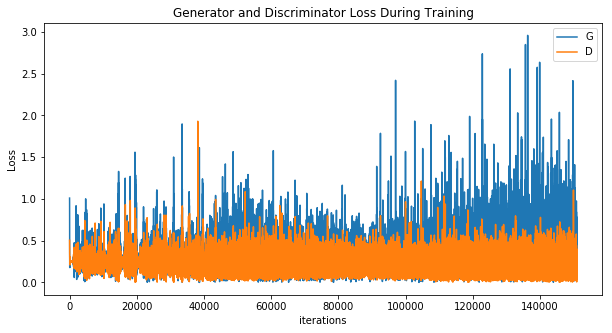

In [14]:
#generate loss function plot and save in the same folder
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig(directoryName+'/lossfunctionplot.png')
plt.show()


**Visualization of G’s progression**

Remember how we saved the generator’s output on the fixed_noise batch
after every epoch of training. Now, we can visualize the training
progression of G with an animation. Press the play button to start the
animation.




In [16]:
#randomly generate 25 images and save them in the same folder
print(imgs.shape[0])
for i in range(302):
    z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], 100))))
    # Generate a batch of images
    gen_imgs = netG(z)
    save_image(gen_imgs.data[:1], directoryName+"/testgen/testoutput"+str(i)+".png", nrow=4, padding=0, normalize=True)

2


In [18]:
#save generator model
torch.save(netG.state_dict(), directoryName+"/netGModel")



In [19]:
torch.save(netD.state_dict(), directoryName+"/netDModel")


In [20]:
#save loss arrays into text files
np.savetxt(directoryName+"/lossG.txt", np.array(G_losses), fmt="%s")
np.savetxt(directoryName+"/lossD.txt", np.array(D_losses), fmt="%s")

In [21]:
print(elapsed_time)

with open(directoryName+'/train_time.txt', 'w') as f:
    f.write('% 0.3f' % (elapsed_time/60))
f.close()

7119.793434381485


In [47]:
#loading the model for inference
directoryName = "LSGANSGD0.0001l16b"
image_size = 128
loadG = Generator(ngpu).to(device)
loadG.load_state_dict(torch.load(directoryName+"/netGModel"))

for i in range(300):
    z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], 100))))
    gen_imgs = loadG(z)
    save_image(gen_imgs.data[:1], directoryName+"/badsgdimg/testoutputloaded"+str(i)+".png", nrow=4, padding=0, normalize=True)



In [ ]:
#using the model for inference
z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], 100))))
gen_imgs = loadG(z)
save_image(gen_imgs.data[:1], directoryName+"/testoutputloaded.png", nrow=4, padding=0, normalize=True)


In [43]:
import numpy as np
import os
from PIL import Image

Image.MAX_IMAGE_PIXELS = None

for filename in os.listdir('data/HTile256/img_align_HTile'):
    if filename.endswith(".jpg"): 
        print(filename)
        
        img = Image.open('data/HTile256/img_align_HTile/'+filename)
        rgbimg = Image.new("RGB", img.size)
        rgbimg.paste(img)
        rgbimg.save('data/HTile256/img_align_HTile/fidtile256/'+filename)
        
    else:
        continue



tile1.jpg
tile10.jpg
tile100.jpg
tile1000.jpg
tile1001.jpg
tile1002.jpg
tile1003.jpg
tile1004.jpg
tile1005.jpg
tile1006.jpg
tile1007.jpg
tile1008.jpg
tile1009.jpg
tile101.jpg
tile1010.jpg
tile1011.jpg
tile1012.jpg
tile1013.jpg
tile1014.jpg
tile1015.jpg
tile1016.jpg
tile1017.jpg
tile1018.jpg
tile1019.jpg
tile102.jpg
tile1020.jpg
tile1021.jpg
tile1022.jpg
tile1023.jpg
tile1024.jpg
tile1025.jpg
tile1026.jpg
tile1027.jpg
tile1028.jpg
tile1029.jpg
tile103.jpg
tile1030.jpg
tile1031.jpg
tile1032.jpg
tile1033.jpg
tile1034.jpg
tile1035.jpg
tile1036.jpg
tile1037.jpg
tile1038.jpg
tile1039.jpg
tile104.jpg
tile1040.jpg
tile1041.jpg
tile1042.jpg
tile1043.jpg
tile1044.jpg
tile1045.jpg
tile1046.jpg
tile1047.jpg
tile1048.jpg
tile1049.jpg
tile105.jpg
tile1050.jpg
tile1051.jpg
tile1052.jpg
tile1053.jpg
tile1054.jpg
tile1055.jpg
tile1056.jpg
tile1057.jpg
tile1058.jpg
tile1059.jpg
tile106.jpg
tile1060.jpg
tile1061.jpg
tile1062.jpg
tile1063.jpg
tile1064.jpg
tile1065.jpg
tile1066.jpg
tile1067.jpg
tile1068.jp

tile312.jpg
tile313.jpg
tile314.jpg
tile315.jpg
tile316.jpg
tile317.jpg
tile318.jpg
tile319.jpg
tile32.jpg
tile320.jpg
tile321.jpg
tile322.jpg
tile323.jpg
tile324.jpg
tile325.jpg
tile326.jpg
tile327.jpg
tile328.jpg
tile329.jpg
tile33.jpg
tile330.jpg
tile331.jpg
tile332.jpg
tile333.jpg
tile334.jpg
tile335.jpg
tile336.jpg
tile337.jpg
tile338.jpg
tile339.jpg
tile34.jpg
tile340.jpg
tile341.jpg
tile342.jpg
tile343.jpg
tile344.jpg
tile345.jpg
tile346.jpg
tile347.jpg
tile348.jpg
tile349.jpg
tile35.jpg
tile350.jpg
tile351.jpg
tile352.jpg
tile353.jpg
tile354.jpg
tile355.jpg
tile356.jpg
tile357.jpg
tile358.jpg
tile359.jpg
tile36.jpg
tile360.jpg
tile361.jpg
tile362.jpg
tile363.jpg
tile364.jpg
tile365.jpg
tile366.jpg
tile367.jpg
tile368.jpg
tile369.jpg
tile37.jpg
tile370.jpg
tile371.jpg
tile372.jpg
tile373.jpg
tile374.jpg
tile375.jpg
tile376.jpg
tile377.jpg
tile378.jpg
tile379.jpg
tile38.jpg
tile380.jpg
tile381.jpg
tile382.jpg
tile383.jpg
tile384.jpg
tile385.jpg
tile386.jpg
tile387.jpg
tile388.jpg